In [1]:
!pip install pandas numpy scikit-learn matplotlib


In [6]:
import pandas as pd

url = "https://raw.githubusercontent.com/COEN498-691-PROJECT/ML_project/main/data/processed/COEN498-691_HAR_preprocessed_dataset.csv"
data = pd.read_csv(url)

print("✅ Data loaded successfully!")
print(data.shape)
data.head()


✅ Data loaded successfully!
(4751, 39)


,ax_mean,ax_std,ax_max,ax_min,ax_range,ax_skew,ax_kurt,ax_zcr,ay_mean,ay_std,...,ayG_mean,azG_mean,Gx,Gy,Gz,Gx_angle,Gy_angle,Gz_angle,activity_id,participant_id
0,-0.002040,0.007937,0.013687,-0.024382,0.038069,-0.428371,1.735067,0,0.000018,0.003702,...,-1.023843,0.187873,0.065561,-0.981462,0.180096,1.505189,2.948741,1.389712,1,LL
1,0.004890,0.009201,0.032755,-0.011421,0.044177,1.177575,2.846603,0,0.001896,0.004891,...,-1.023652,0.190706,0.069292,-0.980722,0.182708,1.501449,2.944921,1.387056,1,LL
2,-0.010652,0.043875,0.070725,-0.110145,0.180870,-0.535210,0.442954,6,-0.003511,0.019515,...,-1.023306,0.193795,0.073180,-0.979901,0.185575,1.497551,2.940762,1.384139,1,LL
3,-0.006527,0.066108,0.150761,-0.110145,0.260906,0.463284,-0.030079,9,0.000702,0.028293,...,-1.022801,0.197092,0.077102,-0.979012,0.188654,1.493618,2.936354,1.381005,1,LL
4,0.009423,0.055730,0.150761,-0.108607,0.259368,0.306438,0.663858,8,0.002152,0.026648,...,-1.022139,0.200553,0.080937,-0.978070,0.191906,1.489771,2.931781,1.377692,1,LL


In [7]:
# ===== 2. Explore the Dataset =====
# In this part, we look at the dataset to understand what kind of data we have,
# check for missing values, and see how the activities are distributed.
# This also helps us find the correct name of the target column.

print("Dataset Info:")
data.info()

print("\nMissing values in the dataset:", data.isnull().sum().sum())

print("\nActivity distribution in the dataset:")
display(data['activity_id'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4751 entries, 0 to 4750
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ax_mean         4751 non-null   float64
 1   ax_std          4751 non-null   float64
 2   ax_max          4751 non-null   float64
 3   ax_min          4751 non-null   float64
 4   ax_range        4751 non-null   float64
 5   ax_skew         4751 non-null   float64
 6   ax_kurt         4751 non-null   float64
 7   ax_zcr          4751 non-null   int64  
 8   ay_mean         4751 non-null   float64
 9   ay_std          4751 non-null   float64
 10  ay_max          4751 non-null   float64
 11  ay_min          4751 non-null   float64
 12  ay_range        4751 non-null   float64
 13  ay_skew         4751 non-null   float64
 14  ay_kurt         4751 non-null   float64
 15  ay_zcr          4751 non-null   int64  
 16  az_mean         4751 non-null   float64
 17  az_std          475

,count
activity_id,
1,1205
4,1196
3,1184
2,1166


In [11]:
# ===== 3. Prepare the Data =====
# In this part, we separate the features (X) and the target (y),
# split the dataset into training and testing sets,
# and then prepare everything for the model.

from sklearn.model_selection import train_test_split

# The target column (label)
target_col = "activity_id"

# All numeric features except the target column
X = data.select_dtypes(include=["number"]).drop(columns=[target_col])
y = data[target_col]

# ✅ Split the data by participant_id to avoid overlap
from sklearn.model_selection import GroupShuffleSplit

groups = data["participant_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Check if any participant appears in both sets
train_people = set(groups.iloc[train_idx])
test_people = set(groups.iloc[test_idx])
print("People overlap?", not train_people.isdisjoint(test_people))


print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Number of classes:", y.nunique())
print("Class labels:", y.unique())


Train shape: (3801, 37)
Test shape: (950, 37)
People overlap? False
Training set shape: (3801, 37)
Testing set shape: (950, 37)
Number of classes: 4
Class labels: [1 2 3 4]


CV (Group) Accuracy: 0.947 ± 0.091
CV (Group) F1-macro: 0.931 ± 0.122

Test Accuracy: 0.991578947368421
Test F1-macro: 0.991504329004329

Classification Report:
               precision    recall  f1-score   support

           1      0.967     1.000     0.983       236
           2      1.000     0.966     0.983       235
           3      1.000     1.000     1.000       231
           4      1.000     1.000     1.000       248

    accuracy                          0.992       950
   macro avg      0.992     0.991     0.992       950
weighted avg      0.992     0.992     0.992       950



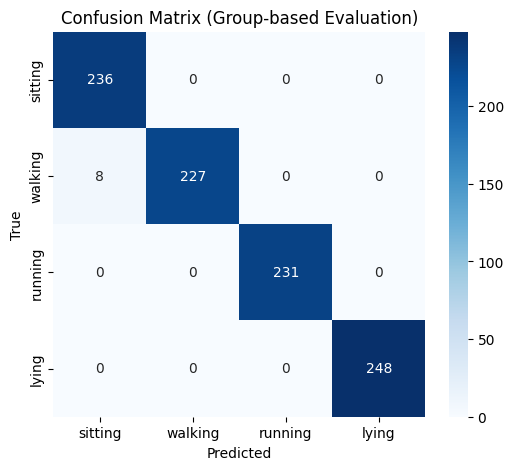

In [13]:
# ===== 4. Train and Evaluate the Logistic Regression Model =====
# In this part, we train a Logistic Regression model and check its performance
# using accuracy, F1-score, and a confusion matrix.

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a pipeline: scaling + model
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

# ✅ 5-fold cross-validation using GroupKFold (based on participant_id)
groups = data["participant_id"]
gkf = GroupKFold(n_splits=5)

scores = cross_validate(pipe, X, y, groups=groups, cv=gkf,
                        scoring=["accuracy", "f1_macro"], n_jobs=-1)

print(f"CV (Group) Accuracy: {scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}")
print(f"CV (Group) F1-macro: {scores['test_f1_macro'].mean():.3f} ± {scores['test_f1_macro'].std():.3f}")

# ✅ Train on full training set
pipe.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipe.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1-macro:", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# ✅ Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['sitting','walking','running','lying'],
            yticklabels=['sitting','walking','running','lying'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Group-based Evaluation)")
plt.show()
